# Sensitivity Experiments

### Setup

**Imports, GPU-Settings and Flags:**

In [4]:
import os
import jax
import pickle as pkl
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import Dict
from matplotlib import cm, colors
from matplotlib.ticker import FormatStrFormatter

from configs.config import get_experiment_config, get_model_config
from src.util.internal_data_construction.sensitivity import SensitivityAnalyser

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
devices = jax.devices()

rerun_models = False
rerun_analyses = False
store_results = False

path_sensitivity_fully = 'experiment_results/linear_seq_fully/sensitvity_all.pkl'
path_sensitivity_nonlin = 'experiment_results/nonlinear_seq_fully/sensitvity_all_nonlin.pkl'
path_sensitivity_partobs = 'experiment_results/linear_seq_partial/sensitvity_all_partobs.pkl'

print(f'Running on Devices: {devices},\nRe-Run Analysis: {rerun_analyses}, \nRe-Run Models: {rerun_models}, \nStore Results: {store_results}')

Running on Devices: [CpuDevice(id=0)],
Re-Run Analysis: False, 
Re-Run Models: False, 
Store Results: False


**Define Models:**

<font color='grey'>Arguments for Model-Config, Seperated by '.':</font> <br>
    - model: Defines Model Type (fixed settings for all other fields). See config.py file for further information.<br>
    - layers: No. of layers in the Transformer. For certain model types (such as those used here), we have layers = 'True' model-layers - 1, as we add another special layer which incorporates the PE-logic in the attention. Thus, a six-layer model is actually seven layers deep. A layer comprises of the multi-head attention mechanism as well as potentially various types of (Layer-) Normalization mechanisms, MLPs and standard residual connections.<br>
    - heads: No. of attention heads.<br>
    - embed_dim: Dimension of embeddings used for computations in the Transformer. <br>
    - seq_len: Length of input sequence lengths.<br>
    - key_size: Key-size per head in attention. <br>
    - pe_kq: Use Positional encodings in keys/queries in special first layer instead of adding them to the residual stream.<br>
    - pe_emb: Use standard Positional encodings, added to the residual stream before the first Transformer layer. <br>
    - laynorm: Use standard Layer-Normalization in each Transformer layer.<br>
    - mlp: Use standard MLP in Transformer layers. Activation function is GeLu (jax.nn.gelu).<br>
    - dim_mlp: Dimension of hidden MLP layers.<br>
    - linear: Use linear self-attention.<br>
    - clip: Use forward-pass activation clipping (of the residual stream).<br>
    - clip_val: Clipping bandwidth (i.e. x <- Clip(x, min=-clip_val, max=clip_val)). <br>
    - schlagnorm: Use 'Schlag-Normalization' as proposed by Schlag, 2021: Separate Normalization of query and key projections in the attention-mechanism.<br>
    - schlagnorm_t: Also normalize value projections.<br>
    - schlagnorm_hyb: Use Schlag-Norm in the first layer.<br>
    - schlagnorm_t_hyb: Also normalize value projections in the first layer.<br>

In [6]:
models = {'full_seven_sm':      'fully_obs_full_fledged_transformer.6.4.40.50.20.True.False.False.False.0.False.False.0.False.False.False.False',
          'full_mesa':          'fully_obs_full_fledged_mesa.1.4.40.50.20.True.False.False.False.0.False.True.1.False.False.False.False',
          'just_mesa':          'just_mesa.1.4.40.50.20.True.False.False.False.0.False.True.1.False.False.False.False',
          'partobs_seven_sm':   'part_obs_full_fledged_transformer.6.12.80.50.20.True.False.False.False.0.False.False.0.False.False.False.False',
          'partobs_mesa':       'part_obs_full_fledged_mesa.1.12.80.50.20.True.False.False.False.0.False.True.1.False.False.False.False',
          'nonlin_seven_sm':    'nonlinear_full_fledged_transformer.6.4.60.50.20.True.False.False.True.300.False.False.0.True.False.False.False',
          'nonlin_mesa':        'fully_obs_full_fledged_mesa.1.4.60.50.20.True.False.False.True.300.False.True.15.True.False.False.False'}

### Experiments (Training on fully observable linear dynamical system):

In [7]:
if rerun_analyses:    
    seeds = [1, 11, 111, 1111, 11111]
    exp_config_sensitivity_fully = get_experiment_config(experiment='sensitivity', seeds=seeds)
    exp_config_sensitivity_j_mesa_fully = get_experiment_config(experiment='sensitivity', seeds=seeds)
    exp_config_sensitivity_j_mesa_fully.optim.peak_lr = 3e-4
    sensitivtiy_result_dict_sm_fully = SensitivityAnalyser(model_config=get_model_config(models['full_seven_sm']), experiment_config=exp_config_sensitivity_fully).run()
    sensitivtiy_result_dict_mesa_fully = SensitivityAnalyser(model_config=get_model_config(models['full_mesa']), experiment_config=exp_config_sensitivity_fully).run()
    sensitivtiy_result_dict_j_mesa_fully = SensitivityAnalyser(model_config=get_model_config(models['just_mesa']), experiment_config=exp_config_sensitivity_j_mesa_fully).run()
    result_dict_fully = {'sensitivtiy_result_dict_sm' : sensitivtiy_result_dict_sm_fully,
                         'sensitivtiy_result_dict_mesa' : sensitivtiy_result_dict_mesa_fully,
                         'sensitivtiy_result_dict_just_mesa' : sensitivtiy_result_dict_j_mesa_fully}
    if store_results:
        with open(path_sensitivity_fully, 'wb') as handle:
            pkl.dump(result_dict_fully, handle, protocol=pkl.HIGHEST_PROTOCOL)
        print(f'Storing results in {path_sensitivity_fully}')
else:
    with open(path_sensitivity_fully, 'rb') as handle:
        result_dict_fully = pkl.load(handle)
    sensitivtiy_result_dict_sm_fully = result_dict_fully['sensitivtiy_result_dict_sm']
    sensitivtiy_result_dict_mesa_fully = result_dict_fully['sensitivtiy_result_dict_mesa']
    sensitivtiy_result_dict_j_mesa_fully = result_dict_fully['sensitivtiy_result_dict_just_mesa']

### Experiments (Training on nonlinear dynamical system):

In [8]:
if rerun_analyses:    
    exp_config_sensitivity_nonlin = get_experiment_config(experiment='nonlin', seeds=[1, 11, 111, 1111, 11111])
    sensitivtiy_result_dict_sm_nonlin = SensitivityAnalyser(model_config=get_model_config(models['nonlin_seven_sm']), experiment_config=exp_config_sensitivity_nonlin).run()
    sensitivtiy_result_dict_mesa_nonlin = SensitivityAnalyser(model_config=get_model_config(models['nonlin_mesa']), experiment_config=exp_config_sensitivity_nonlin).run()
    result_dict_nonlin = {'sensitivtiy_result_dict_sm' : sensitivtiy_result_dict_sm_nonlin,
                          'sensitivtiy_result_dict_mesa' : sensitivtiy_result_dict_mesa_nonlin}
    if store_results:
        with open(path_sensitivity_nonlin, 'wb') as handle:
            pkl.dump(result_dict_nonlin, handle, protocol=pkl.HIGHEST_PROTOCOL)
        print(f'Storing results in {path_sensitivity_nonlin}')
else:
    with open(path_sensitivity_nonlin, 'rb') as handle:
        result_dict_nonlin = pkl.load(handle)
    sensitivtiy_result_dict_sm_nonlin = result_dict_nonlin['sensitivtiy_result_dict_sm']
    sensitivtiy_result_dict_mesa_nonlin = result_dict_nonlin['sensitivtiy_result_dict_mesa']

### Experiments (Training on partially observable linear dynamical system):

In [9]:
if rerun_analyses:    
    exp_config_sensitivity_partobs = get_experiment_config(experiment='partobs', seeds=[1, 11, 111, 1111, 11111])
    sensitivtiy_result_dict_sm_partobs = SensitivityAnalyser(model_config=get_model_config(models['partobs_seven_sm']), experiment_config=exp_config_sensitivity_partobs).run()
    sensitivtiy_result_dict_mesa_partobs = SensitivityAnalyser(model_config=get_model_config(models['partobs_mesa']), experiment_config=exp_config_sensitivity_partobs).run()
    result_dict_partobs = {'sensitivtiy_result_dict_sm' : sensitivtiy_result_dict_sm_partobs,
                          'sensitivtiy_result_dict_mesa' : sensitivtiy_result_dict_mesa_partobs}
    if store_results:
        with open(path_sensitivity_partobs, 'wb') as handle:
            pkl.dump(result_dict_partobs, handle, protocol=pkl.HIGHEST_PROTOCOL)
        print(f'Storing results in {path_sensitivity_partobs}')
else:
    with open(path_sensitivity_partobs, 'rb') as handle:
        result_dict_partobs = pkl.load(handle)
    sensitivtiy_result_dict_sm_partobs = result_dict_partobs['sensitivtiy_result_dict_sm']
    sensitivtiy_result_dict_mesa_partobs = result_dict_partobs['sensitivtiy_result_dict_mesa']

### Visualization of Results

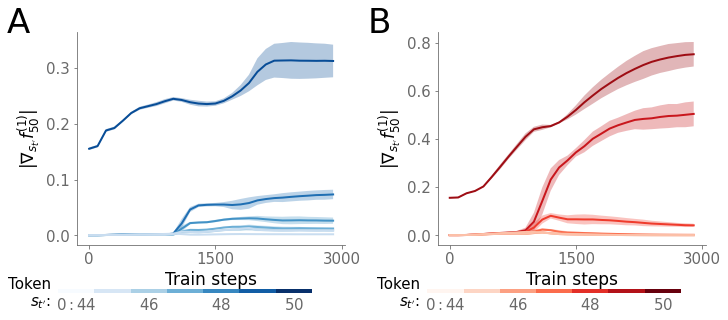

In [18]:
def plot_sensitivities(sensitivity_result_dicts_sm: Dict[str, any],
                       sensitivity_result_dicts_mesa: Dict[str, any],
                       sensitivity_result_dicts_just_mesa: Dict[str, any],
                       sensitivity_range: int,
                       sensitivity_train_len: int):
    
    def subplot_sensitivity(ax, 
                            cols, 
                            sensitivity_dict: Dict[str, any], 
                            analysis_range: int,
                            train_len: int,
                            linestyle: str):
        cols.reverse()
        plt_train_len = train_len//100
        (mean_results, std_results, yavg_results) = sensitivity_dict['sensitivity_lists'][-1] # show probe for probe last token in sequence
        for i, mean, std in zip(range(len(mean_results)), mean_results, std_results):
            c = cols[i]
            ax.plot(mean[:plt_train_len], linewidth=2, color=c, linestyle=linestyle, label=f'$d={i}$')
            ax.fill_between(range(len(mean[:plt_train_len])), 
                            list(jnp.array(mean[:plt_train_len]) - jnp.array(std[:plt_train_len])), 
                            list(jnp.array(mean[:plt_train_len]) + jnp.array(std[:plt_train_len])), 
                            alpha=0.3, 
                            facecolor=c)
        y_avg = yavg_results[0]
        ax.plot(y_avg[:plt_train_len], linewidth=2, color=cols[-1], linestyle=linestyle, label='$t'+'<'+str(50-analysis_range)+'$')
        ax.set_ylabel(r"$\| \nabla_{s_{t'}} f_{50}^{(1)}\|$")
        ax.set_xticks([0,(plt_train_len)//2,plt_train_len],[0,train_len//2,train_len])
        ax.set_xlabel("Train steps")
        ax.tick_params(axis='x', colors='dimgray')
        ax.tick_params(axis='y', colors='dimgray')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_color('dimgray')
        ax.spines['left'].set_color('dimgray')
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', labelsize=17)
    plt.rcParams.update({
        "text.usetex": False,
    })
    just_two_plots = sensitivity_result_dicts_just_mesa == None
    num_graphs = sensitivity_range + 1
    colormap_sm, colormap_mesa, colormap_just_mesa = tuple([plt.get_cmap(col, 100) for col in ['Blues', 'Reds', 'Purples']])
    subplot_col_fn = lambda colmap : [colmap(i) for i in [10+(80//num_graphs)*(k+1) for k in range(num_graphs)]]

    fig, axs = plt.subplots(nrows=1, 
                            ncols=2 if just_two_plots else 3,
                            figsize=(10 if just_two_plots else 14, 4), 
                            gridspec_kw={'width_ratios': ([1,1] if just_two_plots else [1,1,1])},
                            layout='constrained')
    
    ################################################
    subplot_sensitivity(ax=axs[0], 
                        cols=subplot_col_fn(colormap_sm), 
                        sensitivity_dict=sensitivity_result_dicts_sm,
                        analysis_range=sensitivity_range, 
                        train_len=sensitivity_train_len,
                        linestyle='solid')
    
    # Corresponding Colorbar:
    box = axs[0].get_position()
    cbar_height = 0.015
    space_between = 0.0
    cbar_offset = 0.13
    cbar_ax1 = fig.add_axes([box.x0 - 0.05, box.y0 - cbar_offset, box.width, cbar_height])

    cmap = colormap_sm
    bounds = [1,2,3,4,5,6,7,8]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    cs1 = fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap=colormap_sm),
                 orientation='horizontal',
                 cax=cbar_ax1)

    mid_points = [(bounds[i] + bounds[i + 1]) / 2 for i in range(len(bounds) - 1)]
    cs1.set_ticks(mid_points)
    cs1.set_ticklabels(["$0:44$", "", "$46$", "","$48$","","$50$"],color='dimgray')

    cbar_ax1.set_frame_on(False)
    cbar_ax1.set_frame_on(False)
    cbar_ax1.xaxis.set_tick_params(size=0)
    label_y_position = box.y0 - cbar_offset - (cbar_height / 2) - space_between / 2
    fig.text(box.x0 - 0.06, label_y_position+0.005, 'Token\n$s_{t\'}$:', va='center', ha='right', rotation='horizontal', )
    
    ################################################
    subplot_sensitivity(ax=axs[1], 
                        cols=subplot_col_fn(colormap_mesa), 
                        sensitivity_dict=sensitivity_result_dicts_mesa,
                        analysis_range=sensitivity_range, 
                        train_len=sensitivity_train_len,
                        linestyle='solid')
    
    # Corresponding Colorbar:
    box = axs[1].get_position()
    cbar_height = 0.015
    space_between = 0.0
    cbar_offset = 0.13
    cbar_ax1 = fig.add_axes([box.x0 + 0.04, box.y0 - cbar_offset, box.width, cbar_height])

    cmap = colormap_mesa
    bounds = [1,2,3,4,5,6,7,8]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    cs1 = fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap=colormap_mesa),
                 orientation='horizontal',
                 cax=cbar_ax1)

    mid_points = [(bounds[i] + bounds[i + 1]) / 2 for i in range(len(bounds) - 1)]
    cs1.set_ticks(mid_points)
    cs1.set_ticklabels(["$0:44$", "", "$46$", "","$48$","","$50$"],color='dimgray')

    cbar_ax1.set_frame_on(False)
    cbar_ax1.set_frame_on(False)
    cbar_ax1.xaxis.set_tick_params(size=0)
    label_y_position = box.y0 - cbar_offset - (cbar_height / 2) - space_between / 2
    fig.text(box.x0 + 0.03, label_y_position+0.005, 'Token\n$s_{t\'}$:', va='center', ha='right', rotation='horizontal', )
    
    ###########################################
    if not just_two_plots:
        subplot_sensitivity(ax=axs[2], 
                            cols=subplot_col_fn(colormap_just_mesa), 
                            sensitivity_dict=sensitivity_result_dicts_just_mesa,
                            analysis_range=sensitivity_range, 
                            train_len=sensitivity_train_len,
                            linestyle='solid')
        # Corresponding Colorbar:
        box = axs[2].get_position()
        cbar_height = 0.015
        space_between = 0.0
        cbar_offset = 0.13
        cbar_ax1 = fig.add_axes([box.x0 + 0.07, box.y0 - cbar_offset, box.width, cbar_height])

        cmap = colormap_just_mesa
        bounds = [1,2,3,4,5,6,7,8]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        cs1 = fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap=colormap_just_mesa),
                    orientation='horizontal',
                    cax=cbar_ax1)

        mid_points = [(bounds[i] + bounds[i + 1]) / 2 for i in range(len(bounds) - 1)]
        cs1.set_ticks(mid_points)
        cs1.set_ticklabels(["$0:44$", "", "$46$", "","$48$","","$50$"],color='dimgray')

        cbar_ax1.set_frame_on(False)
        cbar_ax1.set_frame_on(False)
        cbar_ax1.xaxis.set_tick_params(size=0)
        label_y_position = box.y0 - cbar_offset - (cbar_height / 2) - space_between / 2
        fig.text(box.x0 + 0.06, label_y_position+0.005, 'Token\n$s_{t\'}$:', va='center', ha='right', rotation='horizontal', )
        ################################################
    
    label_size = 34  # Size of the labels
    axs[0].text(-0.26, 1.12, 'A', transform=axs[0].transAxes, fontsize=label_size, va='top')
    axs[1].text(-0.26, 1.12, 'B', transform=axs[1].transAxes, fontsize=label_size, va='top')


    if store_results:
        fig.savefig('sensitivities_nonlin.pdf', bbox_inches='tight', pad_inches=0.1)
    plt.show()

plot_sensitivities(sensitivity_result_dicts_sm = sensitivtiy_result_dict_sm_nonlin,
                    sensitivity_result_dicts_mesa = sensitivtiy_result_dict_mesa_nonlin,
                    sensitivity_result_dicts_just_mesa = None, 
                    sensitivity_range = 5,
                    sensitivity_train_len = 3000)